In [67]:
protein = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 0, 0],  # activities
    [1, 0, 0],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    protein,
    n_start=3,
    n_generate=50,
    endo_or_exo_probability=[0.5, 0.5],
    enzymes=enzymes,
)
print(len(sequence_graph.edges()))

 49 / 50 (88)
26 unique peptides. 53 total
56


 99 / 100 | 0.10, kl: 0.10, reg: 0.00  | nz: 96 | 

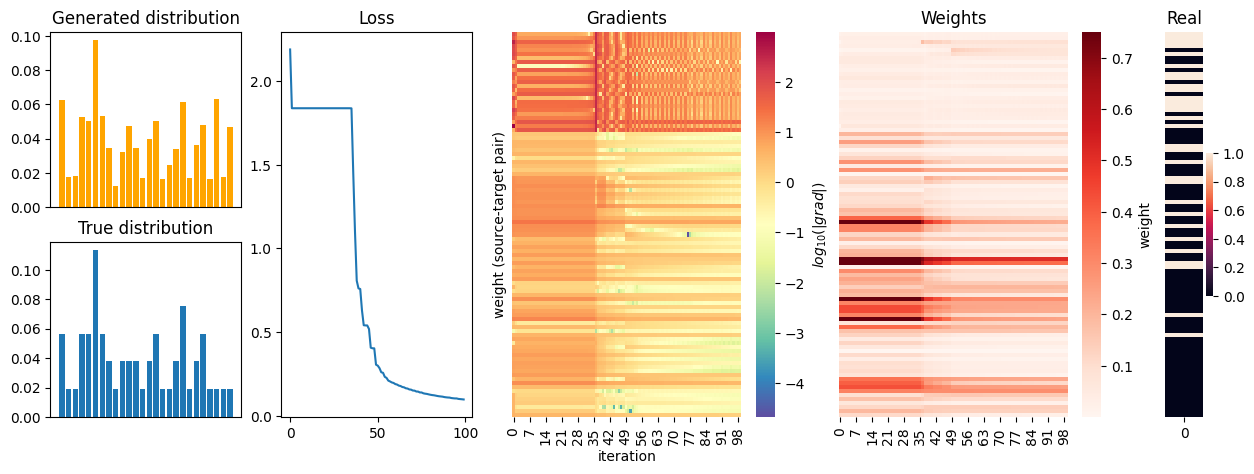

In [68]:
from disassembly.estimate_weights_gd import WeightEstimatorGD

lr_scheduler = {}
steps = [20, 50, 100, 400, 500]
lrs = [1, 0.1, 0.01, 0.001, 0.001]
for lr, step in zip(lrs, steps):
    for i in range(step):
        if i not in lr_scheduler:
            lr_scheduler[i] = lr


wegd = WeightEstimatorGD(lr=0.1, n_iterations=100, lr_scheduler=lr_scheduler)
G = wegd.run(P, verbose=True)
generated = wegd.generated
losses = wegd.losses
weights = wegd.weights

fig, axs = plt.subplot_mosaic(
    [
        ["generated", "loss", "gradients", "weights", "real"],
        ["true", "loss", "gradients", "weights", "real"],
    ],
    width_ratios=[2, 2, 3, 3, 0.5],
    figsize=(15, 5),
)

import numpy as np
import seaborn as sns
import pandas as pd

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated[len(generated.keys()) - 1].keys(),
    generated[len(generated.keys()) - 1].values(),
    color="orange",
)

axs["loss"].plot(losses)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["loss"].set_title("Loss")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
gradients = pd.DataFrame(wegd.gradients).apply(np.abs).apply(np.log10)
sns.heatmap(
    gradients,
    cmap="Spectral_r",
    cbar_kws={"label": r"$log_{10}(|grad|)$"},
    ax=axs["gradients"],
)
axs["gradients"].set_yticks([])
axs["gradients"].set_xlabel("iteration")
axs["gradients"].set_ylabel("weight (source-target pair)")
axs["gradients"].set_title("Gradients")

dataframes = []
for iteration, dataframe in wegd.weights.items():
    dataframe.rename(columns={"weight": iteration}, inplace=True)
    dataframes.append(dataframe)
weights = pd.concat(dataframes, axis=1)


sns.heatmap(weights, ax=axs["weights"], cbar_kws={"label": r"weight"}, cmap="Reds")
axs["weights"].set_yticks([])
axs["weights"].set_ylabel("")
axs["weights"].set_title("Weights")

import networkx as nx

real_weights = nx.to_pandas_edgelist(sequence_graph).set_index(["source", "target"]).merge(
    weights, left_index=True, right_index=True, how="right"
).fillna(0)["weight"].loc[weights.index]
sns.heatmap(np.reshape(real_weights.values, (len(real_weights.values), -1)), ax=axs["real"])
axs["real"].set_yticks([])
axs["real"].set_ylabel("")
axs["real"].set_title("Real")

plt.show()

0.15569320180469526

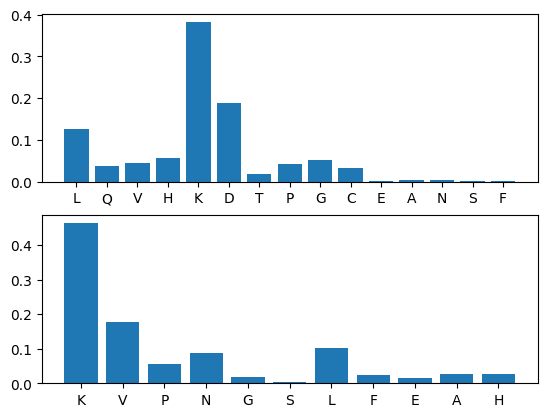

In [ ]:
from disassembly.cut_site import get_p1

p1, p1_exo, exo, endo = get_p1(G, 5000)
fig, axs = plt.subplots(2, 1)
axs[0].bar(p1.keys(), height=p1.values())
axs[1].bar(p1_exo.keys(), height=p1_exo.values())
endo / (exo + endo)

In [ ]:
from disassembly.disassembly import get_disassembly_indexes_mc
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes_mc(sequence_graph, N_particles=10000)
get_disassembly(P, real_disassembly_indexes)


 Averaged DI: 2.12


15.435209466282734

In [ ]:
from disassembly.disassembly import get_disassembly_indexes_mc

mc_di = get_disassembly_indexes_mc(G, 10000)
get_disassembly(P, mc_di)


 Averaged DI: 2.74


27.409713208082938

Text(0.5, 0.98, 'Disassembly indexes')

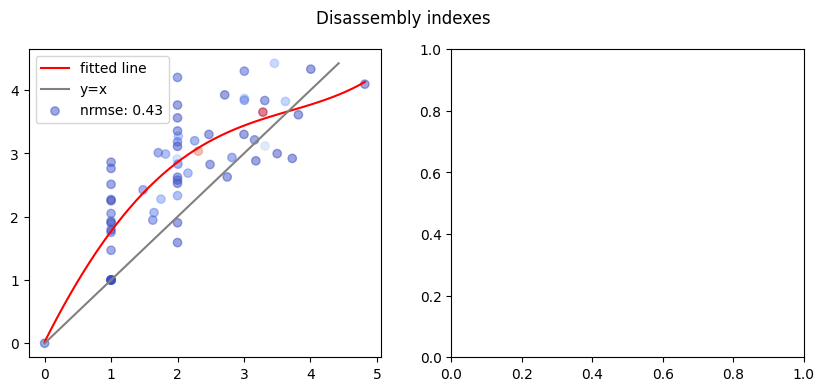

In [ ]:
from scipy.stats import linregress
import numpy as np

# fig, axs = plt.subplots(1,3, figsize=(12,4))
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
trues = []
ys_e = []
ys_mc = []
c = []


def get_nrmse(true, observed):
    true = np.array(true)
    observed = np.array(observed)
    rmse = np.sqrt(np.mean((true - observed) ** 2))
    nrmse = rmse / np.mean(true)
    return nrmse


for key in P.keys():
    if str(np.mean(mc_di[key])) == "nan":
        print(key)
        continue
    trues.append((real_disassembly_indexes[key]))
    # ys_e.append((estimated_disassembly_indexes[key]))
    ys_mc.append(mc_di[key])
    c.append(P[key])
a = 0
# for xs, ys in [(trues, ys_e), (trues, ys_mc), (ys_e, ys_mc)]:
for xs, ys in [(trues, ys_mc)]:
    regress = np.polyfit(xs, ys, 4)
    nrmse = get_nrmse(xs, ys)
    axs[a].plot(
        np.linspace(0, max(xs)),
        regress[0] * np.linspace(0, max(xs)) ** 4
        + regress[1] * np.linspace(0, max(xs)) ** 3
        + regress[2] * np.linspace(0, max(xs)) ** 2
        + regress[3] * np.linspace(0, max(xs))
        + regress[4],
        label="fitted line",
        color="red",
    )
    axs[a].plot(
        np.linspace(0, max(ys)), np.linspace(0, max(ys)), color="gray", label="y=x"
    )
    axs[a].scatter(xs, ys, label=f"nrmse: {nrmse:.2f}", c=c, cmap="coolwarm", alpha=0.5)
    axs[a].legend()
    a += 1

plt.suptitle("Disassembly indexes")

In [ ]:
import networkx as nx
import pandas as pd

aG = pd.DataFrame(
    nx.adjacency_matrix(G, nodelist=G.nodes()).toarray().T,
    index=G.nodes(),
    columns=G.nodes(),
).sort_index(key=lambda x: x.str.len())
aG = aG[aG.index]
pG = pd.DataFrame(
    nx.adjacency_matrix(sequence_graph, nodelist=G.nodes()).toarray().T,
    index=sequence_graph.nodes(),
    columns=sequence_graph.nodes(),
).sort_index(key=lambda x: x.str.len())
pG = pG[pG.index]

113 35.35846261375889 129.4219806695049


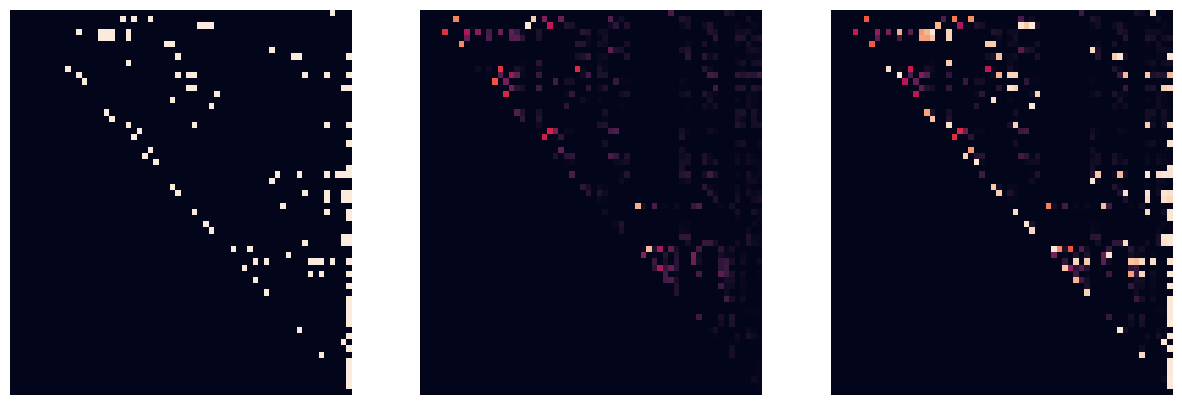

In [ ]:
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(pG, ax=axs[0], cbar=None)
sns.heatmap(aG, ax=axs[1], cbar=None)
sns.heatmap(np.abs(pG - aG), ax=axs[2], cbar=None)

print(sum(sum(pG.values)), sum(sum(aG.values)), sum(sum(np.abs(pG - aG).values)))

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])